In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [8]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [9]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [10]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [11]:
ml_list={"LR":{"SYN":LogisticRegression(C=3.12528 ,penalty="none",solver="lbfgs" ),
               "HTTP":LogisticRegression(C=1.39267 ,penalty="l1",solver="liblinear" ),
               "ACK":LogisticRegression(C=  0.000174804,penalty="none",solver="lbfgs" ),    
               "UDP":LogisticRegression(C=0.000508345 ,penalty="none",solver="lbfgs" ),    
               "ARP":LogisticRegression(C= 7.21375e-05,penalty="l2",solver="newton-cg" ),
               "SP":LogisticRegression(C=50.8013 ,penalty="l1",solver="liblinear" ),    
               "BF":LogisticRegression(C= 5.70815e-05,penalty="l2",solver="liblinear" )    
              },

         

"DT":{"SYN":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=35,min_samples_split=6 ),
"HTTP":DecisionTreeClassifier(criterion="entropy",max_depth=16,max_features=2,min_samples_split=2),                      
"ACK":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=2,min_samples_split=8 ),            
"UDP":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=11,min_samples_split=2 ),            
"ARP":DecisionTreeClassifier(criterion="entropy",max_depth=28,max_features=27,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="gini",max_depth=4,max_features=16,min_samples_split=9 ),            
"BF":DecisionTreeClassifier(criterion="gini",max_depth=19,max_features=10,min_samples_split=3 )},
         

            
    
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=6,max_features=5,min_samples_split=9,n_estimators=73),
"HTTP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=14,max_features=9,min_samples_split=2,n_estimators=7),                      
"ACK":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=4,max_features=9,min_samples_split=7,n_estimators=183 ),            
"UDP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=6,max_features=5,min_samples_split=10,n_estimators=7 ),            
"ARP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=25,max_features=1,min_samples_split=3,n_estimators=48),            
"SP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=6,max_features=5,min_samples_split=6,n_estimators=29),            
"BF":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=18,max_features=2,min_samples_split=2,n_estimators=125 )},      
             

         
"KNN":{"SYN":KNeighborsClassifier(algorithm="auto",leaf_size=42,n_neighbors=6,weights="distance"),
"HTTP":KNeighborsClassifier(algorithm="brute",leaf_size=7,n_neighbors=4,weights="distance"),                     
"ACK":KNeighborsClassifier(algorithm="auto",leaf_size=11,n_neighbors=4,weights="distance"),        
"UDP":KNeighborsClassifier(algorithm="auto",leaf_size=23,n_neighbors=4,weights="distance"),       
"ARP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=5,n_neighbors=16,weights="distance"),         
"SP":KNeighborsClassifier(algorithm="kd_tree",leaf_size=33,n_neighbors=3,weights="distance"),         
"BF":KNeighborsClassifier(algorithm="kd_tree",leaf_size=38,n_neighbors=2,weights="distance")},
   
   
"SVM":{"SYN":SVC(gamma=0.001,C=1),
"HTTP":SVC(gamma=0.1,C=1),                  
"ACK":SVC(gamma=0.1,C=10),   
"UDP":SVC(gamma=1,C=10),   
"ARP":SVC(gamma=0.01,C=10),       
"SP":SVC(gamma=0.01,C=10),    
"BF":SVC(gamma=1,C=10)},
         
    
"MLP":{"SYN":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (901, ), alpha= 0.1, activation='relu'),
"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (408,), alpha= 0.001, activation='tanh'),             
"ACK":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (95, ), alpha= 0.01, activation='relu'),
"UDP":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (1043, ), alpha= 0.0001, activation='tanh'),
"ARP":MLPClassifier(solver= 'sgd', learning_rate= 'adaptive', hidden_layer_sizes= (1637, ), alpha= 0.0001, activation='tanh'),    
"SP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1533, ), alpha= 0.05, activation='relu'), 
"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (892, 1585), alpha= 0.001, activation='tanh')},
         
         
"NB":{"SYN":GaussianNB(var_smoothing=2.84804e-06 ),
"HTTP":GaussianNB(var_smoothing= 2.84804e-09  ),                  
"ACK":GaussianNB(var_smoothing=1e-09  ),
"UDP":GaussianNB(var_smoothing=1e-09),  
"ARP":GaussianNB(var_smoothing=1e-09  ),    
"SP":GaussianNB(var_smoothing=2.31013e-09 ),      
"BF":GaussianNB(var_smoothing=0.1 )},      
         

         
"XGB":{"SYN":xgboost.XGBClassifier(n_estimators=100,min_child_weight=1,max_depth=2,learning_rate=0.15),
"HTTP":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=1,max_depth=2,learning_rate=0.2),                 
"ACK":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=3,learning_rate=0.1),
"UDP":xgboost.XGBClassifier(n_estimators=500,min_child_weight=4,max_depth=2,learning_rate=0.05),
"ARP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=3,max_depth=3,learning_rate=0.2),    
"SP":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=1,max_depth=2,learning_rate=0.1),   
"BF":xgboost.XGBClassifier(n_estimators=900,min_child_weight=2,max_depth=10,learning_rate=0.15)}}


In [12]:
ml_list={   
"SVM":{"SYN":SVC(gamma=0.001,C=1),
"HTTP":SVC(gamma=0.1,C=1),                  
"ACK":SVC(gamma=0.1,C=10),   
"UDP":SVC(gamma=1,C=10),   
"ARP":SVC(gamma=0.01,C=10),       
"SP":SVC(gamma=0.01,C=10),    
"BF":SVC(gamma=1,C=10)},
         
    
"MLP":{"SYN":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (901, ), alpha= 0.1, activation='relu'),
"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (408,), alpha= 0.001, activation='tanh'),             
"ACK":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (95, ), alpha= 0.01, activation='relu'),
"UDP":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (1043, ), alpha= 0.0001, activation='tanh'),
"ARP":MLPClassifier(solver= 'sgd', learning_rate= 'adaptive', hidden_layer_sizes= (1637, ), alpha= 0.0001, activation='tanh'),    
"SP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1533, ), alpha= 0.05, activation='relu'), 
"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (892, 1585), alpha= 0.001, activation='tanh')}   }


In [13]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [14]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [15]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [16]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  



                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [17]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# GA output

In [18]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [14]:
file_list={'./csvs\\dos-synflooding-1-dec.pcap_Flow.csv':"SYN",
'./csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv':"HTTP",
'./csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv':"ACK",
 './csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv':"UDP",
 './csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv':"ARP",
'./csvs\\scan-hostport-3-dec.pcap_Flow.csv':"SP",
 './csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv':"BF"}

./csvs\dos-synflooding-1-dec.pcap_Flow.csv
['Src Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  SVM   0.996      0.5   0.498    0.5  0.499      0    0.5   62.756    16.6

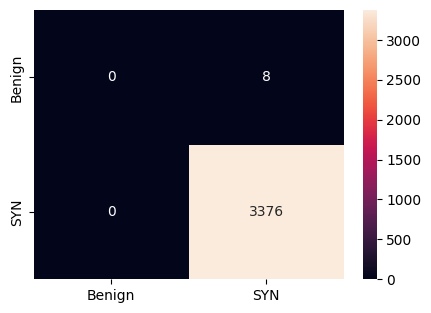





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  MLP   1        1       1      1      1      1      1       12.019     0.043
 1  SYN           0    2     0  MLP   1        1       1      1      1      1      1       17.503     0.038
 2  SYN           0    3     0  MLP   0.999    1       0.812  1      0.884  0.769  1       17.653     0.041
 3  SYN           0    4     0  MLP   0.999    0.889   0.937  0.889  0.912  0.823  0.889   28.723     0.047
 4  SYN           0    5     0  MLP   1        1       1      1      1      1      1       16.245     0.042
 5  SYN           0    1     1  MLP   1        0.95    1      0.95   0.974  0.947  0.95    20.433     0.048
 6  SYN           0    2     1  MLP   1        0.958   1      0.958  0.978  0.956  0.958   52.355     0.037
 7  SYN           0    3

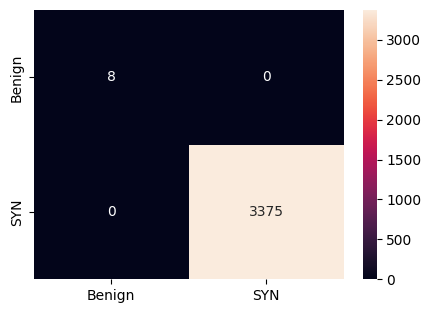





./csvs\mirai-httpflooding-4-dec.pcap_Flow.csv
['Dst Port', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Tot', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  SVM   0.62     0.514   0.808  0.514  0.408  0.034  0.514    0.23      0.089
 1  HTTP          0    2     0  SVM   0.63     0.505   0.648  0.505  0.4    0.013  0.505    0.235     0.094
 2  HTTP          0    3     0  SVM   0.601    0.503   0.8    0.503  0.381  0.008  0.503    0.228     0.11
 3  HTTP          0    4     0  SVM   0.606    0.511   0.702  0.511  0.402  0.027  0.511    0.233     0.094
 4  HTTP          0    5     0  SVM   0.611    0.507   0.805  0.507  0.392  0.017  0.507    0.237     0.093
 5  HTTP          0    1     1  SVM   0.628    0.5     0.314  0.5    0.386  0      0.5      0

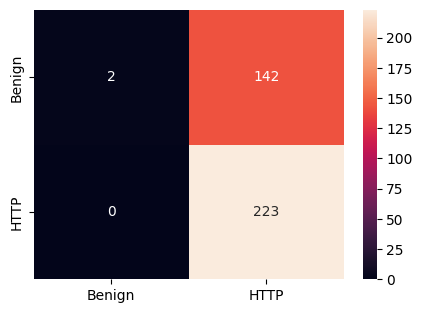





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  MLP   0.802    0.756   0.851  0.756  0.769  0.553  0.756    1.899     0.008
 1  HTTP          0    2     0  MLP   0.812    0.773   0.861  0.773  0.785  0.584  0.773    3.278     0.01
 2  HTTP          0    3     0  MLP   0.807    0.753   0.854  0.753  0.769  0.553  0.753    2.817     0.01
 3  HTTP          0    4     0  MLP   0.81     0.757   0.851  0.757  0.773  0.559  0.757    3.107     0.011
 4  HTTP          0    5     0  MLP   0.766    0.718   0.814  0.718  0.725  0.473  0.718    2.442     0
 5  HTTP          0    1     1  MLP   0.769    0.734   0.813  0.734  0.739  0.497  0.734    2.5       0.009
 6  HTTP          0    2     1  MLP   0.807    0.746   0.84   0.746  0.764  0.541  0.746    1.267     0
 7  HTTP          0    3     1  ML

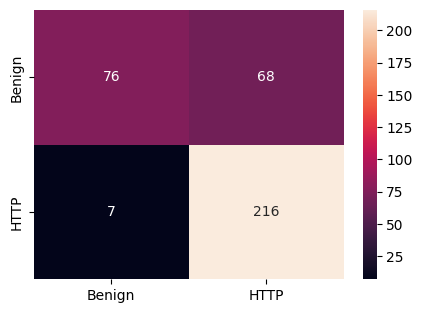





./csvs\mirai-ackflooding-4-dec.pcap_Flow.csv
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s', 'Bwd IAT Std', 'Pkt Len Max', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  SVM   0.911    0.929   0.904  0.929  0.908  0.818  0.929    0.027     0.015
 1  ACK           0    2     0  SVM   0.898    0.907   0.907  0.907  0.898  0.798  0.907    0.055     0.026
 2  ACK           0    3     0  SVM   0.89     0.904   0.897  0.904  0.89   0.782  0.904    0.016     0.032
 3  ACK           0    4     0  SVM   0.873    0.898   0.875  0.898  0.872  0.748  0.898    0.027     0.016
 4  ACK           0

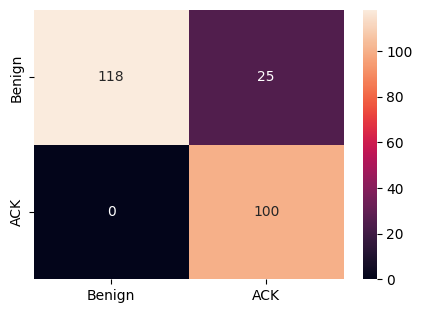





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  MLP   0.894    0.916   0.889  0.916  0.892  0.786  0.916    1.972     0
 1  ACK           0    2     0  MLP   0.89     0.906   0.895  0.906  0.889  0.782  0.906    1.551     0.015
 2  ACK           0    3     0  MLP   0.922    0.928   0.928  0.928  0.922  0.846  0.928    1.765     0
 3  ACK           0    4     0  MLP   0.878    0.898   0.883  0.898  0.877  0.757  0.898    1.893     0
 4  ACK           0    5     0  MLP   0.894    0.911   0.896  0.911  0.893  0.789  0.911    2.004     0
 5  ACK           0    1     1  MLP   0.902    0.917   0.905  0.917  0.902  0.806  0.917    1.981     0
 6  ACK           0    2     1  MLP   0.89     0.907   0.894  0.907  0.889  0.781  0.907    1.767     0.015
 7  ACK           0    3     1  MLP   0.894 

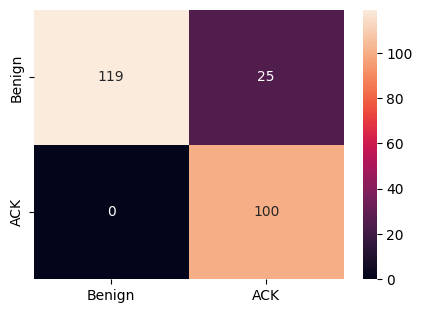





./csvs\mirai-udpflooding-4-dec.pcap_Flow.csv
['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  SVM   0.966      0.5   0.483    0.5  0.491      0    0.5    0.047     0.018
 1  UDP           0    2     0  SVM   0.98       0.5   0.49     0.5  0.495      0    0.5    0.033     0.013
 2  UDP           0    3     0  SVM   0.959      0.5   0.48     0.5  0.49       0    0.5    0.032     0.014
 3  UDP           0    4     0  SVM   0.98       0.5   0.49     0.5  0.495      0    0.5    0.038     0.019
 4  UDP           0    5     0  SVM   0.98       0.5   0.49     0.5  0.495   

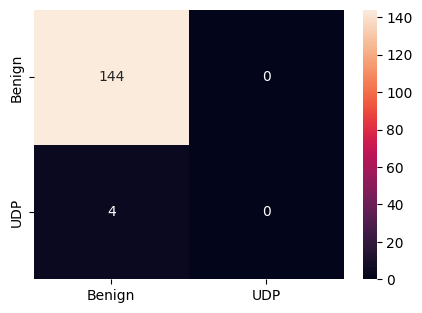





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  MLP   1        1       1      1      1      1      1       22.893     0.016
 1  UDP           0    2     0  MLP   0.98     0.797   0.868  0.797  0.828  0.656  0.797   32.075     0.011
 2  UDP           0    3     0  MLP   1        1       1      1      1      1      1       30.123     0
 3  UDP           0    4     0  MLP   1        1       1      1      1      1      1       23.615     0.004
 4  UDP           0    5     0  MLP   1        1       1      1      1      1      1       23.649     0.011
 5  UDP           0    1     1  MLP   1        1       1      1      1      1      1       31.889     0.011
 6  UDP           0    2     1  MLP   1        1       1      1      1      1      1        2.886     0.019
 7  UDP           0    3    

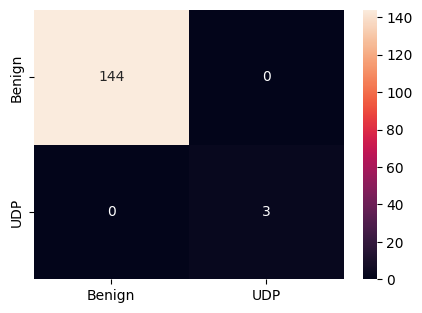





./csvs\mitm-arpspoofing-6-dec.pcap_Flow.csv
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           0    1     0  SVM   0.489    0.5     0.244  0.5    0.328   0      0.5      

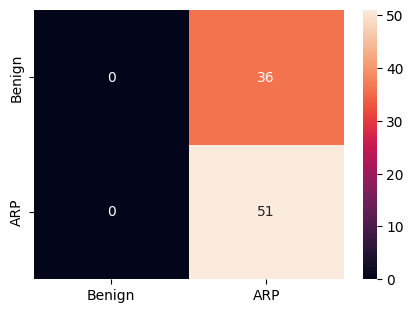





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  MLP   0.7      0.683   0.677  0.683  0.679  0.359  0.683   12.232     0.013
 1  ARP           0    2     0  MLP   0.644    0.661   0.705  0.661  0.63   0.31   0.661   12.399     0.016
 2  ARP           0    3     0  MLP   0.629    0.599   0.62   0.599  0.595  0.208  0.599   12.969     0.011
 3  ARP           0    4     0  MLP   0.697    0.654   0.667  0.654  0.658  0.318  0.654   12.33      0.009
 4  ARP           0    5     0  MLP   0.685    0.639   0.666  0.639  0.642  0.294  0.639   11.862     0.009
 5  ARP           0    1     1  MLP   0.711    0.658   0.671  0.658  0.663  0.328  0.658   11.41      0.008
 6  ARP           0    2     1  MLP   0.6      0.583   0.612  0.583  0.564  0.172  0.583   12.718     0.016
 7  ARP           0    3

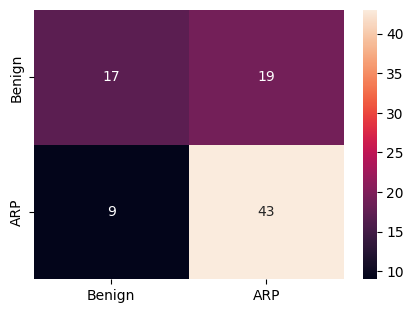





./csvs\scan-hostport-3-dec.pcap_Flow.csv
['Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  SVM   0.961    0.5     0.481  0.5    0.49   0      0.5      0.014     0
 1  SP            0    2     0  SVM   0.957    0.55    0.978  0.55   0.58   0.175  0.55     0.016     0
 2  SP            0    3     0  SVM   0.947    0.542   0.973  0.542  0.563  0.146

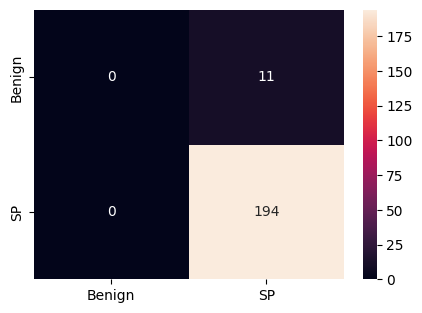





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  MLP   0.99     0.889   0.995  0.889  0.935  0.87   0.889    4.183     0
 1  SP            0    2     0  MLP   0.995    0.997   0.969  0.997  0.983  0.965  0.997    2.321     0.017
 2  SP            0    3     0  MLP   0.908    0.855   0.739  0.855  0.78   0.563  0.855    1.419     0.007
 3  SP            0    4     0  MLP   0.981    0.93    0.847  0.93   0.884  0.768  0.93     2.468     0.006
 4  SP            0    5     0  MLP   1        1       1      1      1      1      1        3.371     0.006
 5  SP            0    1     1  MLP   0.986    0.953   0.92   0.953  0.936  0.872  0.953    2.682     0.014
 6  SP            0    2     1  MLP   0.99     0.9     0.995  0.9    0.942  0.884  0.9      3.592     0.008
 7  SP            0    3    

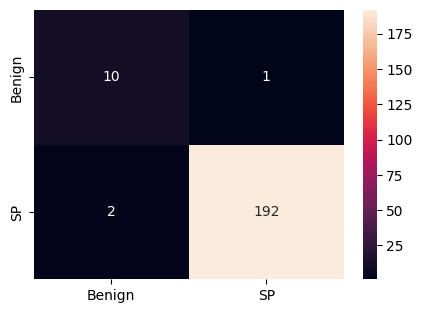





./csvs\mirai-hostbruteforce-5-dec.pcap_Flow.csv
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  SVM   0.802    0.5     0.401  0.5    0.445  0      0.5      0.065     0.026
 1  BF            0    2     0  SVM   0.893    0.5     0.447  0.5    0.472  0      0.5      0.066     0.028
 2  BF            0    3     0  SVM   0.848    0.5     0.424  0.5    0.459  0      0.5      0.059     0.022
 3  BF            0    4     0  SVM   0.863    0.518   0.931  0.518  0.497  0.06   0.518    0.061     0.022
 4  BF            0    5     0  SVM   0.847    0.516   0.923  0.516  0.49   0.053  0.516    0.05      0.03
 5  

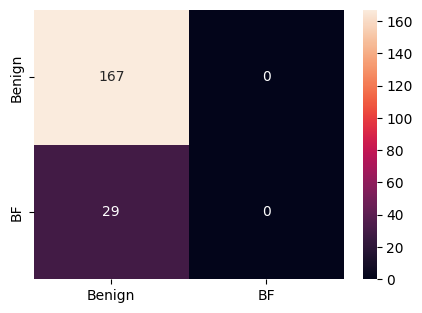





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  MLP   0.843    0.666   0.741  0.666  0.691  0.387  0.666   38.065     0.07
 1  BF            0    2     0  MLP   0.868    0.605   0.653  0.605  0.621  0.246  0.605   42.743     0.059
 2  BF            0    3     0  MLP   0.838    0.6     0.915  0.6    0.62   0.285  0.6     65.585     0.073
 3  BF            0    4     0  MLP   0.878    0.512   0.548  0.512  0.506  0.037  0.512   65.603     0.074
 4  BF            0    5     0  MLP   0.827    0.67    0.661  0.67   0.665  0.331  0.67    55.37      0.054
 5  BF            0    1     1  MLP   0.858    0.602   0.73   0.602  0.627  0.27   0.602   49.366     0.058
 6  BF            0    2     1  MLP   0.822    0.589   0.69   0.589  0.606  0.231  0.589   57.915     0.054
 7  BF            0    3 

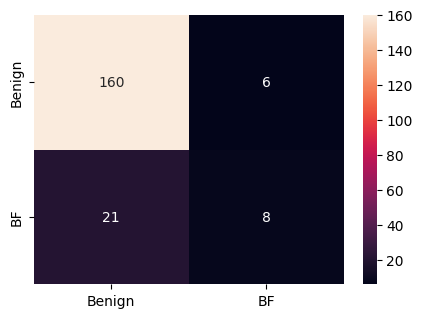

In [15]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# SS

In [16]:
file_list={"SYN":[ './csvs\\dos-synflooding-1-dec.pcap_Flow.csv', './csvs\\dos-synflooding-2-dec.pcap_Flow.csv',],
"HTTP":['./csvs\\mirai-httpflooding-4-dec.pcap_Flow.csv', './csvs\\mirai-httpflooding-1-dec.pcap_Flow.csv'],
"ACK":['./csvs\\mirai-ackflooding-4-dec.pcap_Flow.csv','./csvs\\mirai-ackflooding-1-dec.pcap_Flow.csv'],
"UDP":[ './csvs\\mirai-udpflooding-4-dec.pcap_Flow.csv','./csvs\\mirai-udpflooding-1-dec.pcap_Flow.csv'],
"ARP":[ './csvs\\mitm-arpspoofing-6-dec.pcap_Flow.csv', './csvs\\mitm-arpspoofing-4-dec.pcap_Flow.csv'],
"SP":['./csvs\\scan-hostport-3-dec.pcap_Flow.csv','./csvs\\scan-hostport-4-dec.pcap_Flow.csv'],
"BF":[ './csvs\\mirai-hostbruteforce-5-dec.pcap_Flow.csv','./csvs\\mirai-hostbruteforce-3-dec.pcap_Flow.csv']}

SYN
['Src Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  SVM   0.994      0.5   0.497    0.5  0.498      0    0.5   75.332    51.522
 1  SYN           0    1     1  SVM 

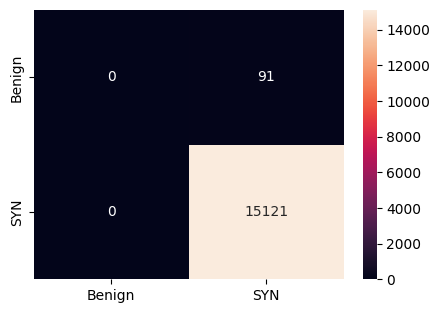





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  MLP   0.998    0.895   0.973  0.895  0.931  0.862  0.895   13.933     0.157
 1  SYN           0    1     1  MLP   0.998    0.944   0.893  0.944  0.917  0.834  0.944   24.364     0.19
 2  SYN           0    1     2  MLP   0.998    0.901   0.95   0.901  0.924  0.848  0.901   25.211     0.205
 3  SYN           0    1     3  MLP   0.997    0.906   0.859  0.906  0.881  0.761  0.906   33.494     0.149
 4  SYN           0    1     4  MLP   0.997    0.906   0.862  0.906  0.883  0.765  0.906   21.909     0.166
 5  SYN           0    1     5  MLP   0.997    0.911   0.882  0.911  0.896  0.792  0.911   19.046     0.204
 6  SYN           0    1     6  MLP   0.998    0.89    0.979  0.89   0.93   0.86   0.89    17.17      0.205
 7  SYN           0    1 

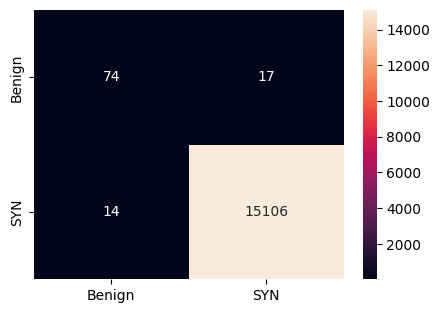





HTTP
['Dst Port', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Tot', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  SVM   0.569    0.503   0.784  0.503  0.369  0.007  0.503    0.382     0.121
 1  HTTP          0    1     1  SVM   0.569    0.503   0.784  0.503  0.369  0.007  0.503    0.365     0.126
 2  HTTP          0    1     2  SVM   0.569    0.503   0.784  0.503  0.369  0.007  0.503    0.362     0.126
 3  HTTP          0    1     3  SVM   0.569    0.503   0.784  0.503  0.369  0.007  0.503    0.384     0.11
 4  HTTP          0    1     4  SVM   0.569    0.503   0.784  0.503  0.369  0.007  0.503    0.355     0.124
 5  HTTP          0    1     5  SVM   0.569    0.503   0.784  0.503  0.369  0.007  0.503    0.363     0.104
 6  HTTP          0    1  

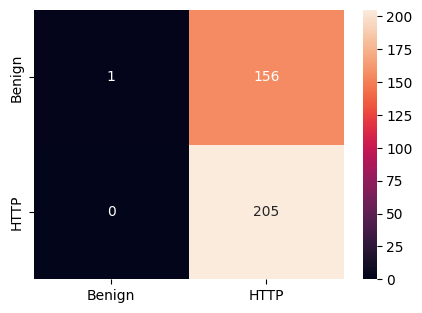





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  MLP   0.804    0.777   0.854  0.777  0.784  0.581  0.777    2.947     0.012
 1  HTTP          0    1     1  MLP   0.812    0.785   0.867  0.785  0.792  0.598  0.785    4.56      0.008
 2  HTTP          0    1     2  MLP   0.798    0.773   0.836  0.773  0.78   0.571  0.773    1.679     0
 3  HTTP          0    1     3  MLP   0.812    0.788   0.852  0.788  0.795  0.601  0.788    2.14      0.016
 4  HTTP          0    1     4  MLP   0.798    0.768   0.864  0.768  0.774  0.567  0.768    3.097     0.01
 5  HTTP          0    1     5  MLP   0.815    0.787   0.872  0.787  0.795  0.604  0.787    3.455     0.007
 6  HTTP          0    1     6  MLP   0.815    0.79    0.86   0.79   0.797  0.606  0.79     2.002     0.016
 7  HTTP          0    1     

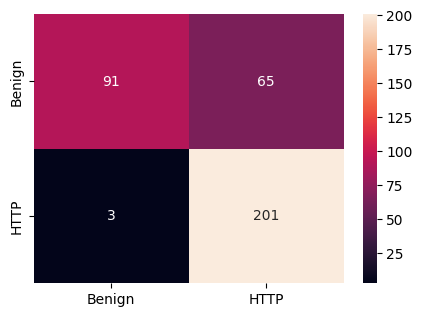





ACK
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s', 'Bwd IAT Std', 'Pkt Len Max', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  SVM   0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.036     0.393
 1  ACK           0    1     1  SVM   0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.032     0.427
 2  ACK           0    1     2  SVM   0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.031     0.414
 3  ACK           0    1     3  SVM   0.997     0.94   0.995   0.94  0.966  0.931   0.94    0.034     0.395
 4  ACK           0    1     4  SVM   0.997     0.94   0.995

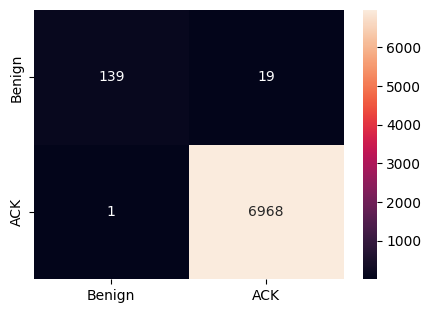





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    2.881     0.007
 1  ACK           0    1     1  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    2.284     0.023
 2  ACK           0    1     2  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    2.265     0.011
 3  ACK           0    1     3  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    2.567     0.013
 4  ACK           0    1     4  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    1.976     0.004
 5  ACK           0    1     5  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    1.848     0.016
 6  ACK           0    1     6  MLP   0.997     0.94   0.995   0.94  0.966  0.931   0.94    2.683     0.016
 7  ACK           0    1

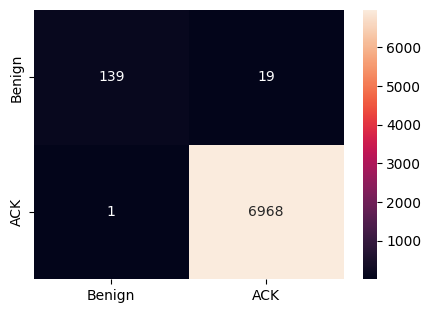





UDP
['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.056     0.047
 1  UDP           0    1     1  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.066     0.052
 2  UDP           0    1     2  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.063     0.053
 3  UDP           0    1     3  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.047     0.063
 4  UDP           0    1     4  SVM   0.406      0.5   0.203    0.5  0.289      0    0.5    0.048     0.063
 5  UDP   

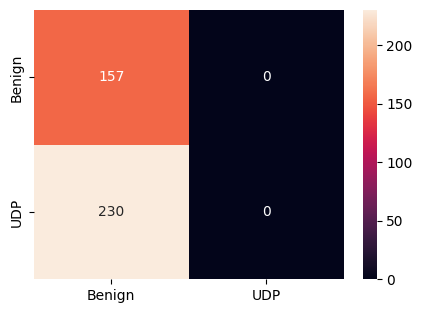





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  MLP   0.478    0.561   0.719  0.561  0.413  0.101  0.561   38.459     0.032
 1  UDP           0    1     1  MLP   0.483    0.565   0.72   0.565  0.421  0.109  0.565   33.769     0.031
 2  UDP           0    1     2  MLP   0.406    0.5     0.203  0.5    0.289  0      0.5     36.966     0.014
 3  UDP           0    1     3  MLP   0.522    0.597   0.719  0.597  0.48   0.163  0.597   36.728     0.035
 4  UDP           0    1     4  MLP   0.491    0.572   0.722  0.572  0.433  0.12   0.572   40.129     0.027
 5  UDP           0    1     5  MLP   0.512    0.589   0.727  0.589  0.463  0.15   0.589   37.184     0.032
 6  UDP           0    1     6  MLP   0.638    0.696   0.764  0.696  0.627  0.343  0.696   37.081     0.034
 7  UDP           0    1

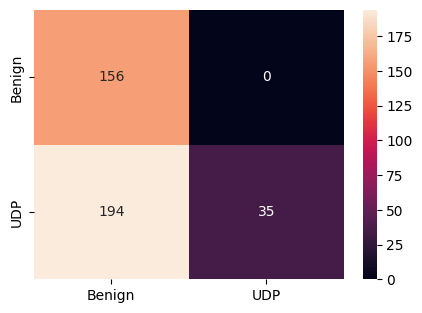





ARP
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  SVM   0.643    0.518   0.819  0.518  0.424  0.044  0.518    0.016     0.031
 1  ARP           0    1   

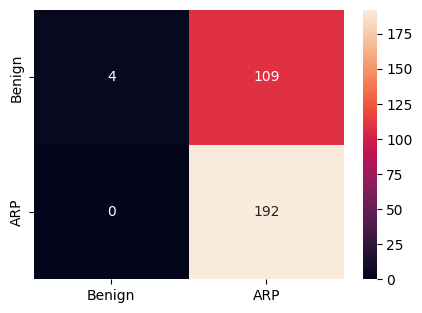





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  MLP   0.662    0.668   0.657  0.668  0.654  0.317  0.668   16.235     0.033
 1  ARP           0    1     1  MLP   0.767    0.757   0.751  0.757  0.753  0.507  0.757   16.267     0.038
 2  ARP           0    1     2  MLP   0.702    0.705   0.692  0.705  0.693  0.39   0.705   16.504     0.033
 3  ARP           0    1     3  MLP   0.692    0.697   0.684  0.697  0.684  0.373  0.697   16.571     0.036
 4  ARP           0    1     4  MLP   0.725    0.727   0.714  0.727  0.715  0.434  0.727   16.297     0.035
 5  ARP           0    1     5  MLP   0.692    0.695   0.683  0.695  0.683  0.371  0.695   16.478     0.032
 6  ARP           0    1     6  MLP   0.652    0.664   0.653  0.664  0.647  0.306  0.664   16.358     0.039
 7  ARP           0    1

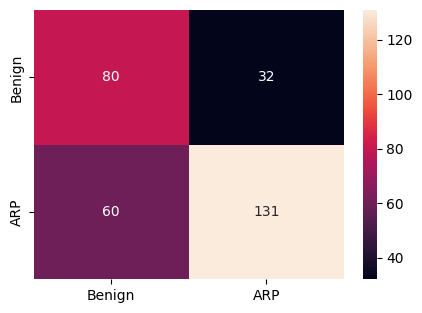





SP
['Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  SVM   0.906      0.5   0.453    0.5  0.475      0    0.5    0.026     0.04
 1  SP            0    1     1  SVM   0.906      0.5   0.453    0.5  0.475      0    0.5    0.02      0.042
 2  SP            0    1     2  SVM   0.906      0.5   0.453    0.5  0.475      0    0.5    0.025     0.046
 3  

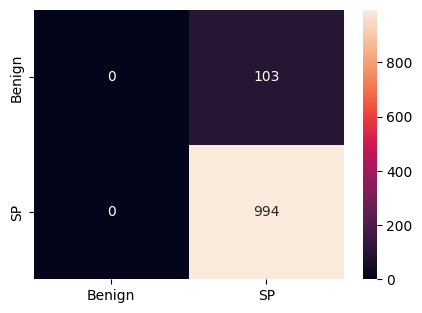





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  MLP   0.928    0.952   0.783  0.952  0.839  0.681  0.952    5.999     0.021
 1  SP            0    1     1  MLP   0.999    0.999   0.995  0.999  0.997  0.995  0.999    2.915     0.012
 2  SP            0    1     2  MLP   0.968    0.974   0.876  0.974  0.917  0.835  0.974    3.793     0.021
 3  SP            0    1     3  MLP   0.936    0.956   0.798  0.956  0.853  0.709  0.956    4.34      0.022
 4  SP            0    1     4  MLP   0.999    0.999   0.995  0.999  0.997  0.995  0.999    2.496     0.022
 5  SP            0    1     5  MLP   0.998    0.995   0.995  0.995  0.995  0.989  0.995    1.637     0.017
 6  SP            0    1     6  MLP   0.986    0.932   0.987  0.932  0.957  0.915  0.932    1.48      0.02
 7  SP            0    1 

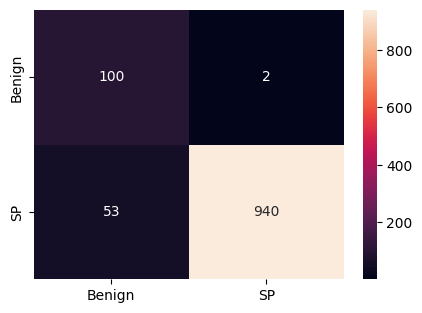





BF
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  BF            0    1     0  SVM   0.848     0.51   0.758   0.51  0.48  0.033   0.51    0.105     0.215
 1  BF            0    1     1  SVM   0.848     0.51   0.758   0.51  0.48  0.033   0.51    0.107     0.198
 2  BF            0    1     2  SVM   0.848     0.51   0.758   0.51  0.48  0.033   0.51    0.104     0.216
 3  BF            0    1     3  SVM   0.848     0.51   0.758   0.51  0.48  0.033   0.51    0.112     0.216
 4  BF            0    1     4  SVM   0.848     0.51   0.758   0.51  0.48  0.033   0.51    0.1       0.204
 5  BF            0    1     5  SVM   0.848     0.51   

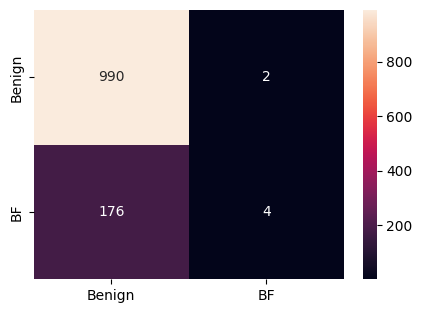





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  MLP   0.863    0.585   0.786  0.585  0.607  0.243  0.585   77.121     0.28
 1  BF            0    1     1  MLP   0.843    0.523   0.638  0.523  0.51   0.071  0.523   57.493     0.271
 2  BF            0    1     2  MLP   0.851    0.573   0.705  0.573  0.589  0.203  0.573   67.845     0.282
 3  BF            0    1     3  MLP   0.851    0.532   0.737  0.532  0.524  0.1    0.532   61.289     0.276
 4  BF            0    1     4  MLP   0.835    0.521   0.588  0.521  0.51   0.061  0.521   38.96      0.216
 5  BF            0    1     5  MLP   0.858    0.607   0.731  0.607  0.633  0.28   0.607   72.079     0.249
 6  BF            0    1     6  MLP   0.846    0.525   0.666  0.525  0.512  0.076  0.525   58.955     0.28
 7  BF            0    1  

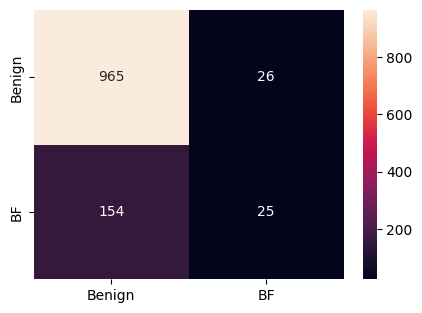

In [17]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   


# TEST

In [18]:
file_list={'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
 'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
 'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
 'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
 'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
 'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
 'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SM/MB-HDis-3.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SM/Scan-HDis-3.csv' ]}

In [19]:
file_list={"SYN":[ './csvs/dos-synflooding-1-dec.pcap_Flow.csv', './csvs/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237.pcap_Flow.csv',],
"HTTP":['./csvs/mirai-httpflooding-4-dec.pcap_Flow.csv', './csvs/NetatmoCamHTTPFlood_1.pcap_Flow.csv'],
"ACK":['./csvs/mirai-ackflooding-4-dec.pcap_Flow.csv','./csvs/NetatmoCamTCPFlood_3.pcap_Flow.csv'],
"UDP":[ './csvs/mirai-udpflooding-4-dec.pcap_Flow.csv','./csvs/Bot_IoT_UDP_DDoS_00001.pcap_Flow.csv'],
"ARP":[ './csvs/mitm-arpspoofing-6-dec.pcap_Flow.csv', './csvs/kitsune_ARP.csv'],
"SP":['./csvs/scan-hostport-3-dec.pcap_Flow.csv','./csvs/scan-hostport-6-dec.pcap_Flow.csv'],
"BF":[ './csvs/mirai-hostbruteforce-5-dec.pcap_Flow.csv','./csvs/AmcrestCamBruteForce_1.pcap_Flow.csv']}

SYN
['Src Port', 'Protocol', 'Flow Duration', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Std', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Min', 'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'SYN Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max', 'Idle Std', 'Idle Max', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  SVM       1      0.5     0.5    0.5   0.5      0    0.5   30.224   397.845
 1  SYN           1    1     1  SVM    

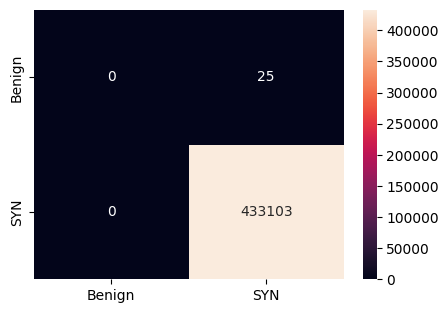





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  MLP   0.613    0.706   0.5    0.706  0.38       0  0.706    7.573     1.967
 1  SYN           1    1     1  MLP   0.071    0.436   0.5    0.436  0.067     -0  0.436    5.817     1.879
 2  SYN           1    1     2  MLP   0.001    0.4     0.492  0.4    0.001     -0  0.4      6.348     1.834
 3  SYN           1    1     3  MLP   0.64     0.52    0.5    0.52   0.39       0  0.52    11.562     1.804
 4  SYN           1    1     4  MLP   0.786    0.793   0.5    0.793  0.44       0  0.793   13.469     1.794
 5  SYN           1    1     5  MLP   0.774    0.787   0.5    0.787  0.437      0  0.787    6.414     1.827
 6  SYN           1    1     6  MLP   0.2      0.5     0.5    0.5    0.166     -0  0.5      8.546     1.837
 7  SYN           1    1

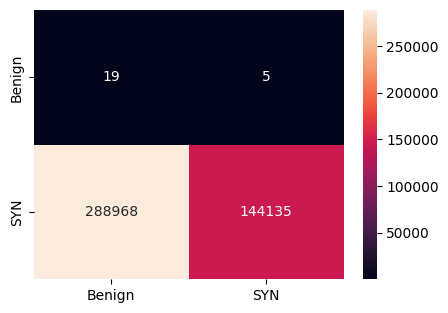





HTTP
['Dst Port', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Tot', 'FIN Flag Cnt', 'SYN Flag Cnt', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  SVM    0.86      0.5    0.43    0.5  0.462      0    0.5    0.135     4.021
 1  HTTP          1    1     1  SVM    0.86      0.5    0.43    0.5  0.462      0    0.5    0.136     3.981
 2  HTTP          1    1     2  SVM    0.86      0.5    0.43    0.5  0.462      0    0.5    0.133     3.991
 3  HTTP          1    1     3  SVM    0.86      0.5    0.43    0.5  0.462      0    0.5    0.139     4.297
 4  HTTP          1    1     4  SVM    0.86      0.5    0.43    0.5  0.462      0    0.5    0.144     4.245
 5  HTTP          1    1     5  SVM    0.86      0.5    0.43    0.5  0.462      0    0.5    0.144     4.241
 6  HTTP          1    1 

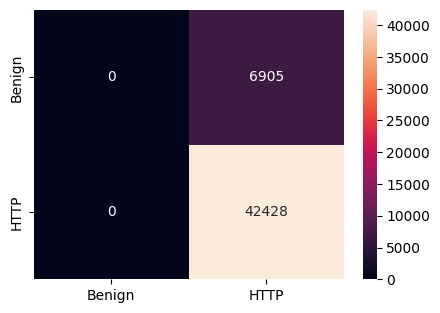





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  HTTP          1    1     0  MLP   0.589    0.345   0.406  0.345  0.373  -0.222  0.345    1.506     0.304
 1  HTTP          1    1     1  MLP   0.545    0.32    0.4    0.32   0.355  -0.236  0.32     1.087     0.309
 2  HTTP          1    1     2  MLP   0.543    0.318   0.399  0.318  0.353  -0.237  0.318    1.137     0.308
 3  HTTP          1    1     3  MLP   0.549    0.322   0.401  0.322  0.357  -0.234  0.322    1.647     0.306
 4  HTTP          1    1     4  MLP   0.546    0.32    0.4    0.32   0.355  -0.236  0.32     1.025     0.306
 5  HTTP          1    1     5  MLP   0.57     0.334   0.403  0.334  0.365  -0.229  0.334    0.827     0.315
 6  HTTP          1    1     6  MLP   0.558    0.327   0.401  0.327  0.36   -0.232  0.327    1.111     0.311
 7  HTTP       

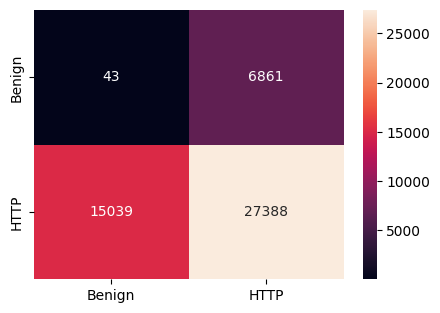





ACK
['TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std', 'Bwd Pkt Len Max', 'Flow Byts/s', 'Bwd IAT Std', 'Pkt Len Max', 'SYN Flag Cnt', 'ACK Flag Cnt', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  SVM   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.033     0.036
 1  ACK           1    1     1  SVM   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.034     0.021
 2  ACK           1    1     2  SVM   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.022     0.021
 3  ACK           1    1     3  SVM   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    0.022     0.021
 4  ACK           1    1     4  SVM   0.116    0.443  

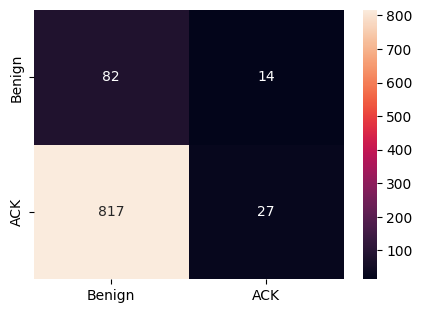





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ACK           1    1     0  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    3.321     0.001
 1  ACK           1    1     1  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    2.405     0.006
 2  ACK           1    1     2  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    2.512     0.002
 3  ACK           1    1     3  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    3.094     0.003
 4  ACK           1    1     4  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    2.517     0.003
 5  ACK           1    1     5  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    3.277     0.001
 6  ACK           1    1     6  MLP   0.116    0.443   0.375  0.443  0.113  -0.024  0.443    3.264     0.001
 7  ACK        

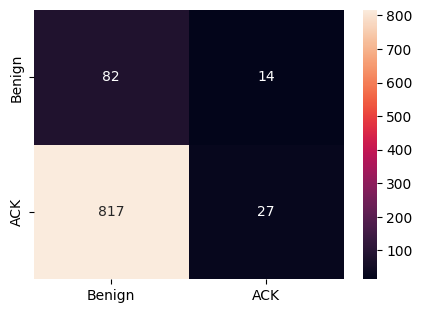





UDP
['Src Port', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Bwd Pkt Len Max', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Pkt Len Max', 'Pkt Size Avg', 'Subflow Bwd Byts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  SVM   0.001      0.5   0.001    0.5  0.001      0    0.5    0.027    12.936
 1  UDP           1    1     1  SVM   0.001      0.5   0.001    0.5  0.001      0    0.5    0.027    12.971
 2  UDP           1    1     2  SVM   0.001      0.5   0.001    0.5  0.001      0    0.5    0.027    12.977
 3  UDP           1    1     3  SVM   0.001      0.5   0.001    0.5  0.001      0    0.5    0.027    12.936
 4  UDP           1    1     4  SVM   0.001      0.5   0.001    0.5  0.001      0    0.5    0.027    12.949
 5  UDP   

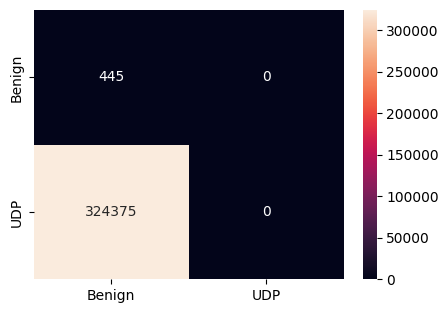





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   37.001     4.543
 1  UDP           1    1     1  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   30.261     4.644
 2  UDP           1    1     2  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   32.735     4.539
 3  UDP           1    1     3  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   28.425     4.56
 4  UDP           1    1     4  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   20.613     4.52
 5  UDP           1    1     5  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   31.225     4.615
 6  UDP           1    1     6  MLP   0.001      0.5   0.001    0.5  0.001      0    0.5   25.284     4.556
 7  UDP           1    1  

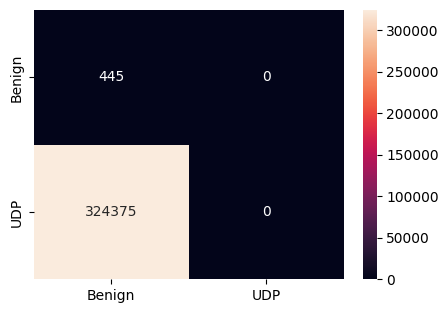





ARP
['Src Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Byts', 'Fwd Act Data Pkts', 'Active Mean', 'Active Std', 'Active Min', 'Idle Mean', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  SVM   0.267      0.5   0.133    0.5  0.211      0    0.5    0.017     0.014
 1  ARP           1    1   

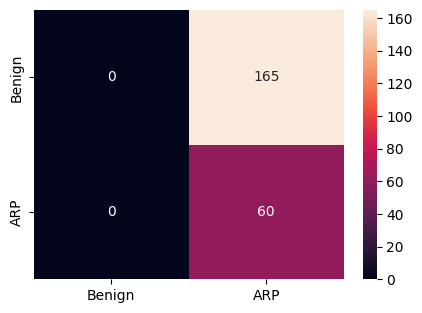





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           1    1     0  MLP   0.8      0.694   0.755  0.694  0.713  0.431  0.694    7.35      0.008
 1  ARP           1    1     1  MLP   0.836    0.718   0.841  0.718  0.749  0.509  0.718    7.426     0.011
 2  ARP           1    1     2  MLP   0.809    0.7     0.773  0.7    0.722  0.45   0.7      7.355     0.01
 3  ARP           1    1     3  MLP   0.813    0.714   0.775  0.714  0.734  0.472  0.714    7.415     0.008
 4  ARP           1    1     4  MLP   0.818    0.695   0.805  0.695  0.722  0.456  0.695    7.338     0.01
 5  ARP           1    1     5  MLP   0.796    0.686   0.748  0.686  0.704  0.415  0.686    7.312     0.01
 6  ARP           1    1     6  MLP   0.871    0.843   0.833  0.843  0.838  0.676  0.843    7.342     0.008
 7  ARP           1    1   

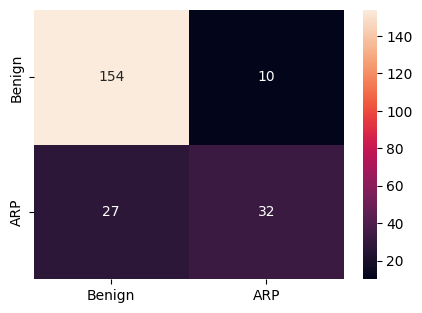





SP
['Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Byts/s', 'Flow IAT Std', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Pkt Len Var', 'SYN Flag Cnt', 'Fwd Seg Size Avg', 'Subflow Bwd Pkts', 'Init Bwd Win Byts', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Std', 'Idle Max', 'Idle Min', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            1    1     0  SVM   0.961      0.5    0.48    0.5  0.49      0    0.5    0.021     0.032
 1  SP            1    1     1  SVM   0.961      0.5    0.48    0.5  0.49      0    0.5    0.013     0.024
 2  SP            1    1     2  SVM   0.961      0.5    0.48    0.5  0.49      0    0.5    0.016     0.027
 3  SP  

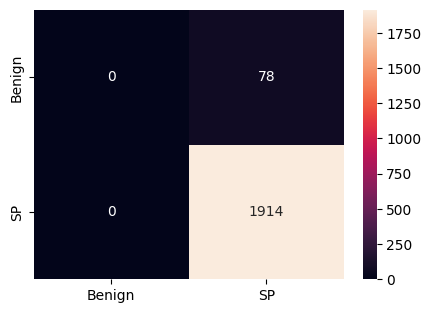





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  MLP   0.951    0.962   0.722  0.962  0.792  0.588  0.962    2.182     0.023
 1  SP            1    1     1  MLP   0.953    0.97    0.728  0.97   0.799  0.602  0.97     1.523     0.019
 2  SP            1    1     2  MLP   0.942    0.939   0.697  0.939  0.763  0.531  0.939    3.159     0.019
 3  SP            1    1     3  MLP   0.986    0.962   0.879  0.962  0.916  0.832  0.962    2.147     0.021
 4  SP            1    1     4  MLP   0.898    0.928   0.635  0.928  0.684  0.386  0.928    0.726     0.022
 5  SP            1    1     5  MLP   0.994    0.985   0.947  0.985  0.965  0.93   0.985    1.633     0.026
 6  SP            1    1     6  MLP   0.951    0.956   0.72   0.956  0.789  0.582  0.956    2.192     0.019
 7  SP            1    1

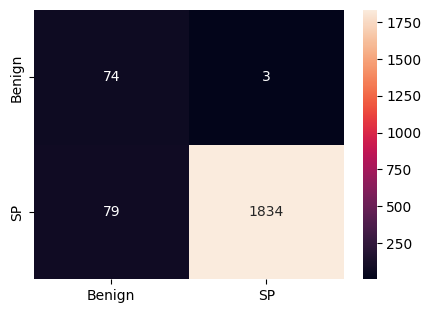





BF
['Tot Bwd Pkts', 'TotLen Fwd Pkts', 'Flow IAT Max', 'Fwd IAT Tot', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Min', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  SVM   0.463      0.5   0.231    0.5  0.316      0    0.5    0.107     0.003
 1  BF            1    1     1  SVM   0.463      0.5   0.231    0.5  0.316      0    0.5    0.06      0.003
 2  BF            1    1     2  SVM   0.463      0.5   0.231    0.5  0.316      0    0.5    0.047     0.004
 3  BF            1    1     3  SVM   0.463      0.5   0.231    0.5  0.316      0    0.5    0.045     0.003
 4  BF            1    1     4  SVM   0.463      0.5   0.231    0.5  0.316      0    0.5    0.047     0.003
 5  BF            1    1     5  SVM   0.463     

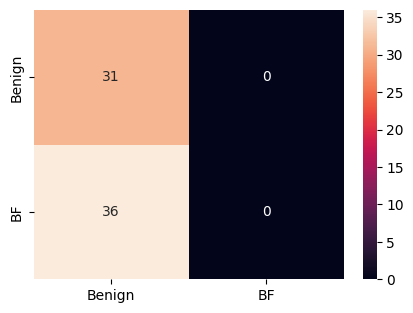





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  MLP   0.552    0.583   0.754  0.583  0.48   0.156  0.583   23.469     0.014
 1  BF            1    1     1  MLP   0.552    0.583   0.754  0.583  0.48   0.156  0.583   23.503     0.013
 2  BF            1    1     2  MLP   0.552    0.583   0.754  0.583  0.48   0.156  0.583   27.437     0.014
 3  BF            1    1     3  MLP   0.463    0.5     0.231  0.5    0.316  0      0.5     17.626     0.015
 4  BF            1    1     4  MLP   0.478    0.514   0.735  0.514  0.347  0.026  0.514   28.8       0.012
 5  BF            1    1     5  MLP   0.463    0.5     0.231  0.5    0.316  0      0.5     48.203     0.015
 6  BF            1    1     6  MLP   0.463    0.5     0.231  0.5    0.316  0      0.5     28.951     0.012
 7  BF            1    1

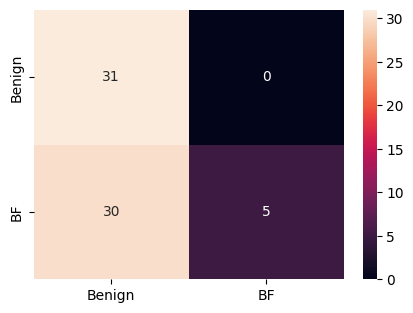

In [20]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  


In [21]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]


    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

100%|██████████████████████████████████████████| 56/56 [00:00<00:00, 125.80it/s]

    Attack    ML            Acc      b_Acc         Prec        Rec           F1           kap        ROC         tra-T         test-T
--  --------  ----  -----------  ---------  -----------  ---------  -----------  ------------  ---------  ------------  -------------
 0  UDP       LR    0.00136999   0.5        0.000684995  0.5        0.00136812    0            0.5         0.0342375      0.00966394
 1  BF        MLP   0.547761     0.579167   0.566098     0.579167   0.442691      0.15459      0.579167   29.6908         0.0126078
 2  ACK       NB    0.252128     0.514292   0.508806     0.514292   0.247336      0.00696068   0.514292    0.000697613    9.97543e-05
 3  HTTP      XGB   0.776762     0.870215   0.692683     0.870215   0.703599      0.443988     0.870215    4.09908        0.207585
 4  ACK       SVM   0.115957     0.443079   0.374875     0.443079   0.112921     -0.024188     0.443079    0.0238798      0.0221774
 5  ACK       RF    0.115957     0.443079   0.374875     0.443079   0.

In [22]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)

UDP
BF
ACK
HTTP
SYN
ARP
SP
